# Predict Future Sales Kaggle Competition

## Quick overview

This notebook is split into five main sections:

- Problem description and a basic overview of the data we provided with.
- Data analysis - I go through each of the datasets and extract important information from them.
- Feature enginnering - I come up with some additional features that the model could use in its favour. I also give shape to the training dataset, so that most information is kept from the original dataframe.
- Creating the model - the most interesting part of this project. After initial analysis of the data, I decided to create quite a peculiar neural network, tailor made for this problem, with multiple inputs and entity embeddings, with the use of `keras` functional API using `TensorFlow` backend.
- Model training and evaluation - I decided to train four different models, in a sort of created k-fold validation. The mean of these four models' predictions is used for the final submission.

## Problem description

The goal of this Data Science competition is to predict future sales of a certain Russian store chain. The task may seem not so complicated at first, but when we read into the problem a little bit, we find out that this is so much more than just a standard timeseries prediction problem. But first things first - let's take a look at the task and what information are we presented with.

The Description says: "In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills."

We also get the information that the submissions will be rated by root mean squared error (RMSE), and that the target values are clipped in between 0 and 20.

Now that we know what we are supposed to achieve in this project, let's dive into the data we are provided with.

### Data

We are provided with six `csv` files:

- `sales_train_v2.csv` contains the training set of daily historical data from January 2013 to October 2015.
- `test.csv` contains the test set. It is basically a list of shop-item pairs that we are supposed to forecast.
- `sample_submission.csv` - a sample submission file in the correct format.
- `item.csv` contains additional information about items.
- `item_categories.csv` contains additional information about the items categories.
- `shops.csv` contains supplemental information about the shops.

In order to extract as much information from this dataset as we probably can, we obviously have to use all of the files that we are provided with. To explore the data, we are going to be using `pandas`, `numpy`, `matplotlib`, and `seaborn` Python modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import datetime
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Activation, Reshape, Dropout
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from IPython.display import Image
import calendar
from sklearn.utils import shuffle

Using TensorFlow backend.


### Data lookup and cleaning

First thing we should do is load the available data, and take a look at what we are dealing with in this task. The Dataframe consists of a record of all sales of a Russian software store chain from January 2013 to October 2015. It consists of a `date` of the sale, `shop_id` - the shop at which it was made, `item_price` at which an item was sold, `item_id` - certain item that was sold, and `item_cnt_day` - the amount of items sold (or returned - the dataframe also consists of returned items). In total there are 2 935 849 records in the dataframe.

When we get back to our original task - predicting sales for the next month - it becomes clear that we have to make some changes to the original dataframe. The main challenge is to create monthly aggregates of sales for a certain item at a certain shop on each of the months. So the first thing to do is change the data from daily records to monthly records.

In [2]:
df = pd.read_csv('sales_train_v2.csv')

In [3]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
df.shape

(2935849, 6)

I plot the number of single sales to see if there are any outliers and to see what are the most common sale numbers. There is clearly one outlier of over 2000 item count for a single sale. I decide to limit the number of single sales to 1000 items max.

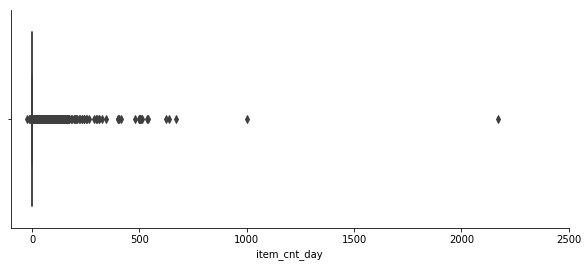

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 2500)
sns.boxplot(x=df.item_cnt_day)
sns.despine()

In [5]:
item_cnt = df.item_cnt_day.values
print('Top 10 single sales:')
for i in range(1,11):
    print(i, np.sort(item_cnt)[-i])

Top 10 single sales:
1 2169.0
2 1000.0
3 669.0
4 637.0
5 624.0
6 539.0
7 533.0
8 512.0
9 508.0
10 504.0


In [6]:
df.loc[df.item_cnt_day > 1000, 'item_cnt_day'] = 1000

In [7]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv', index_col='ID')

Before moving on to the remaining datasets, I plot the number of sales in each of the months that are recorder in the dataframe. There is a clear pattern in the data. The sales follow a trend - they are getting smaller as time goes by. There is also very visible seasonality. The sales are typically at their lowest in the vacation season - July and August - and always peak towards the end of the year, with clearly highest sales recorder in the month of December.

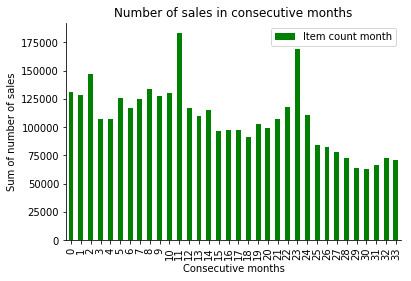

In [4]:
df.pivot_table('item_cnt_day', 'date_block_num', aggfunc='sum').plot.bar(color='g')
plt.ylabel('Sum of number of sales')
plt.xlabel('Consecutive months')
plt.title('Number of sales in consecutive months')
plt.legend(['Item count month'])
sns.despine()

### Shops

The `shops.csv` contains a list of shop names and their IDs in the main dataframe. After a quick look we can spot that there are some shops with the same, or very similar names. After taking a look at the main dataframe we can confirm that some shops are duplicate of one another, in a way that in certain months, the sales are recorder to another shop.

Shop with ID `0` records sales for the first two month. After that period the rest of the sales are recorder to shop with ID `57`.

Shop with ID `1` similarly to shop with ID `0` records sales for the first two months, and then they are assigned to shop with ID `58`.

Shop with ID `10` records all months, apart from February 2015, during which the sales are assigned to shop with ID `11`.

After taking a look at the `test.csv`, to see for which shops we need to predict the future sales, we fix the data.

Then, we take a look at the `shop_name` column again. The first piece of information is always the city where the shop is based. We split the column to extract that information and we come up with the number of unique cities the shops are based in: `31`.

In [8]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [9]:
df[df.shop_id == 0]['date_block_num'].unique()

array([0, 1], dtype=int64)

In [10]:
df[df.shop_id == 57]['date_block_num'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

In [11]:
df[df.shop_id == 1]['date_block_num'].unique()

array([0, 1], dtype=int64)

In [12]:
df[df.shop_id == 58]['date_block_num'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

In [13]:
df[(df.shop_id==10)]['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

In [14]:
df[df.shop_id==11]['date_block_num'].unique()

array([25], dtype=int64)

In [15]:
np.sort(test.shop_id.unique())

array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
       26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
       50, 52, 53, 55, 56, 57, 58, 59], dtype=int64)

In [16]:
df.loc[df.shop_id == 0, 'shop_id'] = 57

df.loc[df.shop_id == 1, 'shop_id'] = 58

df.loc[df.shop_id == 11, 'shop_id'] = 10

The plot below shows registered sales at each of the shops in all of the months contained in the sales dataframe. If a sales is recorded at a certain shop in a certain month, it is marked with a marker. Most of the shops are 'open' for the entire time period considered in the dataframe. However, there are some that 'opens' somewhere in between the start and the end of the analysed period. There are also some shops that are 'closed' at some point.

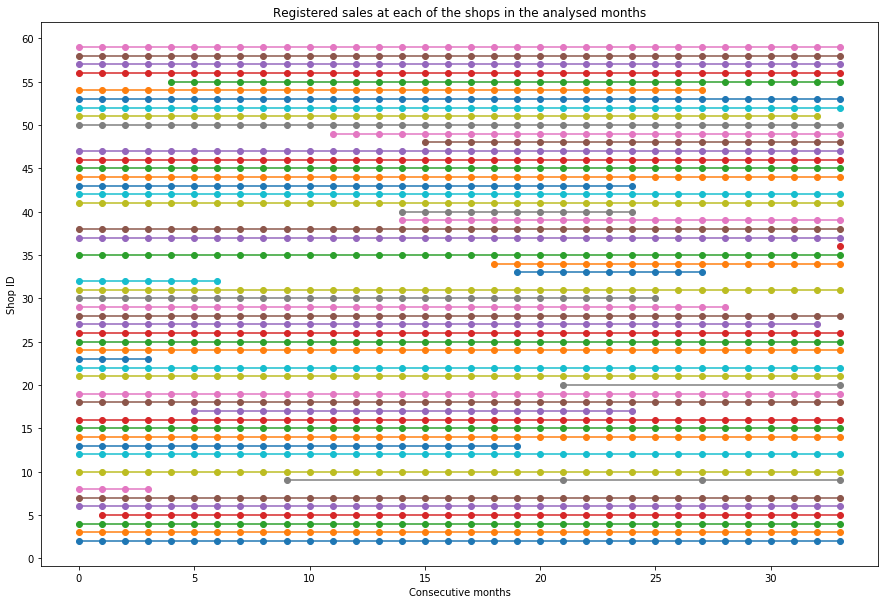

In [17]:
fig = plt.figure(figsize=(15,10))
for shop in np.sort(df.shop_id.unique()):
    a=df[df.shop_id == shop]['date_block_num'].unique()
    b=np.asarray([shop for x in df[df.shop_id == shop]['date_block_num'].unique()])
    plt.plot(a, b, label=shop, marker='o')
plt.xlabel('Consecutive months')
plt.ylabel('Shop ID')
plt.yticks(np.arange(0, 61, 5))
plt.title('Registered sales at each of the shops in the analysed months')
plt.show()

In [18]:
shops['city'] = shops.shop_name.str.split(' ').str[0].str.strip()

In [19]:
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [20]:
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [21]:
print('Number of unique cities:', shops.city.nunique())

Number of unique cities: 31


### Items
The `items.csv` contains a list of all 22 170 unique items, each assigned to a certain `item category`. The items fall into 84 unique categories.

In [22]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [23]:
print('Number of unique items:', items.item_id.nunique())
print('Number of unique categories:', items.item_category_id.nunique())

Number of unique items: 22170
Number of unique categories: 84


### Categories
From the `items.csv` we know that the items are split into 84 categories. In the `item_categories.csv` we find names of those categories. We can also see that the `item_category_name` consists of two pieces of information. It is split by '-' and most often in the first columns there is a name of a subtype (ie. accessories), and after the '-' name of a specific hardware, though it does not always follow that tendency. Nevertheless, we split the the `item_category_name` column into two, and for the sake of future referral, name the first new column `subtype`, and the second new column `subcat` for subcategory.

There are 20 unique subtypes, and 67 unique subcategories.

In [24]:
cat_split = categories.item_category_name.str.split('-', n=1, expand=True)

In [25]:
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [26]:
cat_split = pd.concat([categories.item_category_id, cat_split[0].str.strip(), cat_split[1].str.strip()],axis=1)

In [27]:
cat_split.columns = ['item_category_id', 'subtype', 'subcat']

In [28]:
cat_split.loc[cat_split.isnull().any(axis=1), 'subcat'] = cat_split.subtype

In [29]:
cat_split.head()

,item_category_id,subtype,subcat
0,0,PC,Гарнитуры/Наушники
1,1,Аксессуары,PS2
2,2,Аксессуары,PS3
3,3,Аксессуары,PS4
4,4,Аксессуары,PSP


In [30]:
print('Number of unique subtypes:', cat_split.subtype.nunique())
print('Number of unique subcategories:', cat_split.subcat.nunique())

Number of unique subtypes: 20
Number of unique subcategories: 67


# Sales dataframe preparation

Now let's take a look at our main dataframe again. All of the sales from January 2013 until October 2015 are recorder in it. When we first loaded it in we found out some basic information on the sales. We found out that there is a trend, and seasonalisty in the data. Now we have to look a little bit deeper and find some other important pieces of information.

At first we are going to check if certain days of the week generate more sales than the other. Basic logic might suggest that most of the sales should be made during the weekend. We are going to verify this hypothesis.

I am also calculating revenue generated by each sale, and assessing whether it is an outlier or not. One of the items's price is much higher than the rest so it seems like it could be a typing mistake.

In [31]:
print('Highest prices:')
for i in range(1,6):
    print(i, df[df.item_price == np.sort(df.item_price)[-i]]['item_price'].values[0])

Highest prices:
1 307980.0
2 59200.0
3 50999.0
4 49782.0
5 42990.0


In [32]:
outlier_price_item = df.loc[df.item_price == np.sort(df.item_price)[-1], 'item_id'].values[0]

In [33]:
items[items.item_id == outlier_price_item]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


The item with the highest price is `Radmin 3`, a computer program. The name also says `522 лиц` which I believe stands for 522 people, which means that it is a licence to use this program on 522 computers, so it is possible that this price is not a mistake, so I decide to leave it as it is.

In [34]:
df['revenue'] = df.item_cnt_day * df.item_price

In [35]:
df.date = pd.to_datetime(df.date, format='%d.%m.%Y')

In [36]:
df['weekday'] = df.date.apply(lambda x: datetime.datetime.weekday(x))

The bar chart below shows number of sales from the whole dataframe on different weekdays. It shows that, indeed the most sales are made during the weekend. Most sales are recorded on Saturdays, Sundays take second place, and third goes to Fridays. This finding is important, as we are to predict future sales by month, so we can expect higher sales for the months that consist of more 'weekend' days than the rest.

([<matplotlib.axis.XTick at 0x18ab4a5b860>,
 <a list of 7 Text xticklabel objects>)

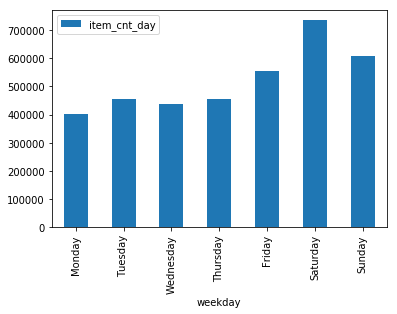

In [37]:
df.pivot_table('item_cnt_day', 'weekday',  aggfunc='sum').plot.bar()
locs, labels = plt.xticks()
plt.xticks(locs, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

([<matplotlib.axis.XTick at 0x18ab4ed30b8>,
 <a list of 7 Text xticklabel objects>)

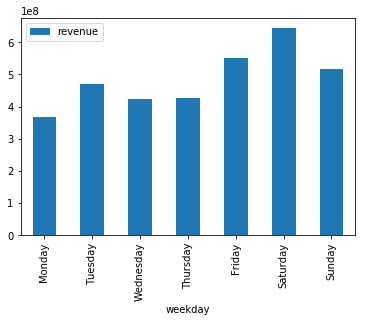

In [38]:
df.pivot_table('revenue', 'weekday',  aggfunc='sum').plot.bar()
locs, labels = plt.xticks()
plt.xticks(locs, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

## Feature engineering and training set creation

After successfully verifying the hypothesis that most sales are registered during the weekends, we have to find a way to use that knowledge to our advantage. Each month can either have 4 or 5 of each day. Except from February, which has exactly 4 of each day. Out assumption is that months with 5 Saturdays or Sundays will generate more sales, and that is a useful information for the model.

In order to use this finding in the model, I create a DataFrame that shows number of each weekdays in the months from January 2013 to December 2015. We will be expecting higher sales in the months with more 'weekend' days. I also add a column of total days in a month, as months with more days will also be expected to generate more sales.

In [39]:
years = [2013, 2014, 2015]
months = [1,2,3,4,5,6,7,8,9,10,11,12]
monday, tuesday, wednesday, thursday, friday, saturday, sunday = calendar.MONDAY, calendar.TUESDAY, calendar.WEDNESDAY, calendar.THURSDAY, calendar.FRIDAY, calendar.SATURDAY, calendar.SUNDAY
days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]
days_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
num_weekdays_df = pd.DataFrame()
i=-1
for day in days:
    i+=1
    num_day = []
    for year in years:
        for month in months:
            cal = calendar.monthcalendar(year,month)
            num_days = sum(1 for x in cal if x[day] != 0)
            num_day.append([month, year, num_days])
            if len(num_day) == 36:
                num_weekdays_df[days_list[i]] = pd.Series(np.asarray(num_day)[:,2],name=days_list[i])
                num_weekdays_df['month'] = pd.Series(np.asarray(num_day)[:,0])
                num_weekdays_df['year'] = pd.Series(np.asarray(num_day)[:,1])
num_weekdays_df = num_weekdays_df[['month', 'year', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

In [40]:
num_weekdays_df['num_days'] = num_weekdays_df.iloc[:, 2:].sum(axis=1)

The dataframe I created consists of information on: month, year, numbers of certain day in that month, and number of days.

In [41]:
num_weekdays_df

,month,year,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,num_days
0,1,2013,4,5,5,5,4,4,4,31
1,2,2013,4,4,4,4,4,4,4,28
2,3,2013,4,4,4,4,5,5,5,31
3,4,2013,5,5,4,4,4,4,4,30
4,5,2013,4,4,5,5,5,4,4,31
5,6,2013,4,4,4,4,4,5,5,30
6,7,2013,5,5,5,4,4,4,4,31
7,8,2013,4,4,4,5,5,5,4,31
8,9,2013,5,4,4,4,4,4,5,30
9,10,2013,4,5,5,5,4,4,4,31


## Training dataset creation

The next step is, what is really crucial in terms of the goal of predicting future sales of a specific item, at a specific shop. Our DataFrame consists of records of single purchases of specific items, at different dates, at different shops. We have to extract all the imporant information from this original state, and transform it so that the model we are going to build, will be able to find any patterns in the data.

In order to do that we have to take a look at the `test.csv`. It contains two columns: `shop_id` and `item_id`, and we know that what we are supposed to predict, is the sales for the next month, which is November 2015. We need to transform the original DataFrame so that it looks similar to the test set. To do that we group the dataframe by month, shop and item_id, and sum the sales.

The dataframe that I am going to use for training is constructed in a way that it creates a time series for each item sold at a specific shop in the months in which the shop was 'open'. So the training set only consists of all possible timeseries that generated at least one sale in the period from January 2013 to October 2015. I leave out all the remaining possible time series that never generated a sale on purpose, as they would only take some redundant memory, and increase the training time by hours. The final training dataset consists of over 13 million rows and 17 columns.

After taking a look at the `test` set, we can see that it consists of a fixed item list repeated for every shop that we need to predict. I decided to come up with another assumption: if a certain shop has never recorded a sale of a certain item, it will not make a sale of this item in the next month. I go through the dataset and come up with a list of such shop - item pairs. It turns out that almost half of the predictions, according to my assumption will have the expected value of 0.

In [42]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,weekday
0,2013-01-02,0,59,22154,999.00,1.0,999.00,2
1,2013-01-03,0,25,2552,899.00,1.0,899.00,3
2,2013-01-05,0,25,2552,899.00,-1.0,-899.00,5
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05,6
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00,1


In [43]:
train_df = pd.DataFrame()
for shop in np.sort(df.shop_id.unique()):
    unique_items = df.loc[df.shop_id == shop, 'item_id'].unique()
    current_shop = np.full(unique_items.shape[0], shop)
    temp_df = pd.DataFrame({'shop_id':current_shop, 'item_id':unique_items})
    train_df = pd.concat([train_df,temp_df])

In [44]:
full_df = pd.DataFrame()
for shop in np.sort(train_df.shop_id.unique()):
    for month in df.loc[df.shop_id == shop, 'date_block_num'].unique():
        temp_df = train_df.loc[train_df.shop_id == shop]
        temp_df['date_block_num'] = month
        full_df = pd.concat([full_df, temp_df])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [45]:
full_df = full_df.reset_index().drop('index', axis=1)

full_df = full_df[['date_block_num', 'shop_id', 'item_id']]

In [46]:
pivot = df.pivot_table('item_cnt_day', ['date_block_num', 'shop_id', 'item_id'], aggfunc='sum')

pivot = pivot.reset_index()

pivot.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']

In [47]:
train = full_df.merge(pivot, how='left', on=['date_block_num', 'shop_id', 'item_id'])

In [48]:
train = train.fillna(0)

In [49]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,weekday
0,2013-01-02,0,59,22154,999.00,1.0,999.00,2
1,2013-01-03,0,25,2552,899.00,1.0,899.00,3
2,2013-01-05,0,25,2552,899.00,-1.0,-899.00,5
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05,6
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00,1


In [50]:
df_grouped = pd.DataFrame(df.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum())
df_grouped = df_grouped.reset_index()
test['date_block_num'] = 34
cols = test.columns.tolist()
cols = cols[-1:] + cols[:-1]
test = test[cols]
temp_df = pd.DataFrame()
for i in range(0,34):
    test['date_block_num'] = i
    temp_df = pd.concat([temp_df, test])
temp_df = temp_df.reset_index()
df_train = temp_df.drop('ID', axis = 1)

In [51]:
df_train = df_train.merge(df_grouped, how='left', on=['date_block_num', 'shop_id', 'item_id'])

df_train = df_train.fillna(0)

In [52]:
df_train.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,0,5,5037,0.0
1,0,5,5320,0.0
2,0,5,5233,0.0
3,0,5,5232,0.0
4,0,5,5268,0.0


The next thing I do is create a pivot table, which consists of all time series from the original data. Each column represents a timeseries we are supposed to predict one period ahead. So there, are exactly 214 200 timeseries we need to predict in order to complete this task.

In [53]:
time_series = pd.pivot_table(df_train, values='item_cnt_day', index='date_block_num', columns=['shop_id','item_id'],aggfunc='sum')

In [54]:
time_series

shop_id           2                                                         \
item_id        30    31    32    33    38    42    45    51    53    57      
date_block_num                                                               
0                0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
1                0.0   4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2                1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3                0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5                1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
6                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
7                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
8                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10               0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0   
11               0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
12               0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
13               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
14               0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
15               1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
16               1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
17               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
18               0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
19               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
20               0.0   0.0   2.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
21               0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
22               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
23               0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
24               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
25               0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   0.0   
26               0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
27               0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
28               0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
29               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30               0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
31               0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
32               0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
33               0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

shop_id         ...     59                                                  \
item_id         ...  22118 22137 22139 22145 22154 22162 22163 22164 22166   
date_block_num  ...                                                          
0               ...    0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
1               ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2               ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3               ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4               ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5               ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
6               ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
7               ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
8               ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9               ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10              ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
11              ...  

Some of the timeseries are likely to be, not consisting of any sales, as some items are not avaiable at specific shops. I find all the timeseries that does not contain any sales, and decide to drop these timeseries from my training set, as they would only take valuable memory space, with the assumption that if a certain shop-item pair did not generate any sales in the past it will not generate any sale in the future.

In [55]:
drop_list = []
for i in range(0,214200):
    if time_series.iloc[:,i].max() == 0:
        drop_list.append(time_series.iloc[:,i].name)

In [64]:
train.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,11330,1.0
1,0,2,11331,1.0
2,0,2,11332,1.0
3,0,2,11015,1.0
4,0,2,11030,1.0


In [57]:
del df_grouped
del df_train
del train_df
del time_series
del temp_df
del pivot
del full_df

In [58]:
test['date_block_num'] = 34

test['item_cnt_month'] = 0

test = pd.pivot_table(test, values='item_cnt_month', index='date_block_num', columns=['shop_id','item_id'])

In [59]:
test

shop_id           2                                                         \
item_id        30    31    32    33    38    42    45    51    53    57      
date_block_num                                                               
34                 0     0     0     0     0     0     0     0     0     0   

shop_id         ...     59                                                  \
item_id         ...  22118 22137 22139 22145 22154 22162 22163 22164 22166   
date_block_num  ...                                                          
34              ...      0     0     0     0     0     0     0     0     0   

shop_id               
item_id        22167  
date_block_num        
34                 0  

[1 rows x 214200 columns]

In [60]:
test = test.unstack().reset_index()

In [61]:
train.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,11330,1.0
1,0,2,11331,1.0
2,0,2,11332,1.0
3,0,2,11015,1.0
4,0,2,11030,1.0


In [63]:
train = train[['shop_id', 'item_id', 'date_block_num', 'item_cnt_month']]

test.columns = ['shop_id', 'item_id', 'date_block_num', 'item_cnt_month']

train['month'] = train['date_block_num'] % 12 + 1

train['year'] = train['date_block_num'].map(lambda x: 2013 if x<=11 else 2014 if x<=23 else 2015)

test['month'] = 11

test['year'] = 2015

test = test[['date_block_num', 'month', 'year', 'shop_id', 'item_id', 'item_cnt_month']]

train = train[['date_block_num', 'month', 'year', 'shop_id', 'item_id', 'item_cnt_month']]

test = test.drop('item_cnt_month', axis=1)

In [64]:
test.head()

,date_block_num,month,year,shop_id,item_id
0,34,11,2015,2,30
1,34,11,2015,2,31
2,34,11,2015,2,32
3,34,11,2015,2,33
4,34,11,2015,2,38


In [65]:
test['item_cnt_month'] = np.nan

## Final data preparation

Some time earlier we came up with some additional features we acquired from the additional datasets. It is time to put all the valuable information into one dataframe that will be used for training. I concatenate the training set and test set together to make all the necessary operations faster (this way I do not have to repeat all the code for the test set separately).

I merge this whole dataset with the other datasets I created earlier. The final form of the dataframe used for training has the following features: 'date_block_num', 'month', 'year', 'shop_id', 'item_category_id', 'item_id', 'subtype', 'subcat', 'city', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'num_days'. The 'item_cnt_month' column is the target for our model.

Before putting all these features into the model, we have to make sure they are properly encoded. It means that each of the features will be represented by an integer, and fed this way into the model. 

After making all these data transformations we split the whole dataset, back into the train dataframe, and the test set.

In [66]:
full_df = pd.concat([train,test])

In [67]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [68]:
cat_split.head()

,item_category_id,subtype,subcat
0,0,PC,Гарнитуры/Наушники
1,1,Аксессуары,PS2
2,2,Аксессуары,PS3
3,3,Аксессуары,PS4
4,4,Аксессуары,PSP


In [69]:
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [70]:
num_weekdays_df.head()

,month,year,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,num_days
0,1,2013,4,5,5,5,4,4,4,31
1,2,2013,4,4,4,4,4,4,4,28
2,3,2013,4,4,4,4,5,5,5,31
3,4,2013,5,5,4,4,4,4,4,30
4,5,2013,4,4,5,5,5,4,4,31


In [71]:
full_df.head()

,date_block_num,month,year,shop_id,item_id,item_cnt_month
0,0,1,2013,2,11330,1.0
1,0,1,2013,2,11331,1.0
2,0,1,2013,2,11332,1.0
3,0,1,2013,2,11015,1.0
4,0,1,2013,2,11030,1.0


In [72]:
train = full_df.merge(items, how='left', on='item_id')
train = train.drop('item_name', axis=1)

In [73]:
train = train.merge(cat_split, how='left', on='item_category_id')

In [74]:
train = train.merge(shops, how='left', on='shop_id').drop('shop_name',axis=1)

In [75]:
train = train.merge(num_weekdays_df, how='left', on=['month', 'year'])

In [76]:
train = train[['date_block_num', 'month', 'year', 'shop_id', 'item_category_id',
       'item_id', 'subtype', 'subcat', 'city', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'num_days', 'item_cnt_month']]

In [77]:
del full_df

In [78]:
date_block_encoder = LabelEncoder()
date_block_encoder.fit(train.date_block_num)
train.date_block_num = date_block_encoder.transform(train.date_block_num)
#train.date_block_num = train.date_block_num.astype('category')

In [79]:
month_encoder = LabelEncoder()
month_encoder.fit(train.month)
train.month = month_encoder.transform(train.month)
#train.month = train.month.astype('category')

In [80]:
year_encoder = LabelEncoder()
year_encoder.fit(train.year)
train.year = year_encoder.transform(train.year)
#train.year = train.year.astype('category')

In [81]:
shop_encoder = LabelEncoder()
shop_encoder.fit(train.shop_id)
train.shop_id = shop_encoder.transform(train.shop_id)
#train.shop_id = train.shop_id.astype('category')

In [82]:
cat_encoder = LabelEncoder()
cat_encoder.fit(train.item_category_id)
train.item_category_id = cat_encoder.transform(train.item_category_id)
#train.item_category_id = train.item_category_id.astype('category')

In [83]:
item_encoder = LabelEncoder()
item_encoder.fit(train.item_id)
train.item_id = item_encoder.transform(train.item_id)
#train.item_id = train.item_id.astype('category')

In [84]:
subtype_encoder = LabelEncoder()
subtype_encoder.fit(train.subtype)
train.subtype = subtype_encoder.transform(train.subtype)
#train.subtype = train.subtype.astype('category')

In [85]:
subcat_encoder = LabelEncoder()
subcat_encoder.fit(train.subcat)
train.subcat = subcat_encoder.transform(train.subcat)
#train.subcat = train.subcat.astype('category')

In [86]:
city_encoder = LabelEncoder()
city_encoder.fit(train.city)
train.city = city_encoder.transform(train.city)
#train.city = train.city.astype('category')

In [87]:
Monday_encoder = LabelEncoder()
Monday_encoder.fit(train.Monday)
train.Monday = Monday_encoder.transform(train.Monday)
#train.Monday = train.Monday.astype('category')

In [88]:
Tuesday_encoder = LabelEncoder()
Tuesday_encoder.fit(train.Tuesday)
train.Tuesday = Tuesday_encoder.transform(train.Tuesday)
#train.Tuesday = train.Tuesday.astype('category')

In [89]:
Wednesday_encoder = LabelEncoder()
Wednesday_encoder.fit(train.Wednesday)
train.Wednesday = Wednesday_encoder.transform(train.Wednesday)
#train.Wednesday = train.Wednesday.astype('category')

In [90]:
Thursday_encoder = LabelEncoder()
Thursday_encoder.fit(train.Thursday)
train.Thursday = Thursday_encoder.transform(train.Thursday)
#train.Thursday = train.Thursday.astype('category')

In [91]:
Friday_encoder = LabelEncoder()
Friday_encoder.fit(train.Friday)
train.Friday = Friday_encoder.transform(train.Friday)
#train.Friday = train.Friday.astype('category')

In [92]:
Saturday_encoder = LabelEncoder()
Saturday_encoder.fit(train.Saturday)
train.Saturday = Saturday_encoder.transform(train.Saturday)
#train.Saturday = train.Saturday.astype('category')

In [93]:
Sunday_encoder = LabelEncoder()
Sunday_encoder.fit(train.Sunday)
train.Sunday = Sunday_encoder.transform(train.Sunday)
#train.Sunday = train.Sunday.astype('category')

In [94]:
num_days_encoder = LabelEncoder()
num_days_encoder.fit(train.num_days)
train.num_days = num_days_encoder.transform(train.num_days)
#train.num_days = train.num_days.astype('category')

In [95]:
num_date_block = train.date_block_num.nunique()
num_shop = train.shop_id.nunique()
num_item = train.item_id.nunique()
num_cat = train.item_category_id.nunique()
num_subtype = train.subtype.nunique()
num_subcat = train.subcat.nunique()
num_city = train.city.nunique()

In [96]:
test = train.loc[train.date_block_num == 34].drop('item_cnt_month', axis = 1)

train = train.loc[train.date_block_num!=34]

## Model creation

After all of the data wrangling, feature engineering, and training dataset creation, it is time for the thing we have all been waiting for. The Model.

After initial data transformation, it became clear to me, that using one-hot-encoding for this dataset might be not quite efficient in terms of memory needed for such process as all of the data I use for the model is categorical. The single feature of `item_id` consists of over 20 000 unique items, and to feed that information into the model would require creating as many dummy features. So I decided that, I have to find another way of defining a representation of a feature. Well, to be fair, there was always one choice for me.

Entity embedding.

With entity embeddings we can map all of the categorical features in a function approximation problem into Euclidean spaces. This mapping is learned by the neural network in the training process. Well, obviously it decreases the memory usage, but what is even better, it also may find some intrinsic properties of the feauture. 

So the entity embedding is the answer to our original problem. Now we have to program it, and give shape to the model. The only way, with the use `keras`, is by using the `Functional API`, which enables multiple inputs to the model (with the commonly used Sequential model we can only apply one input into our models). We need multiple inputs, because we have multiple features, and we want to give all of our features an embedding.

I decided to use 17 features for training so I create a model with 17 inputs. All of the features are then pushed through an embedding layer. Then the result of each of the 17 entity embeddings is concatenated and put through a densely connected layer with 500 neurons, then a dense layer with 100 neurons, and finally the last dense layer with 1 neuron,as we are expecting a single prediction.

Below you can see a visual representation of the model (open in a new tab to be able to see anything), made possible by `tensorboard`.

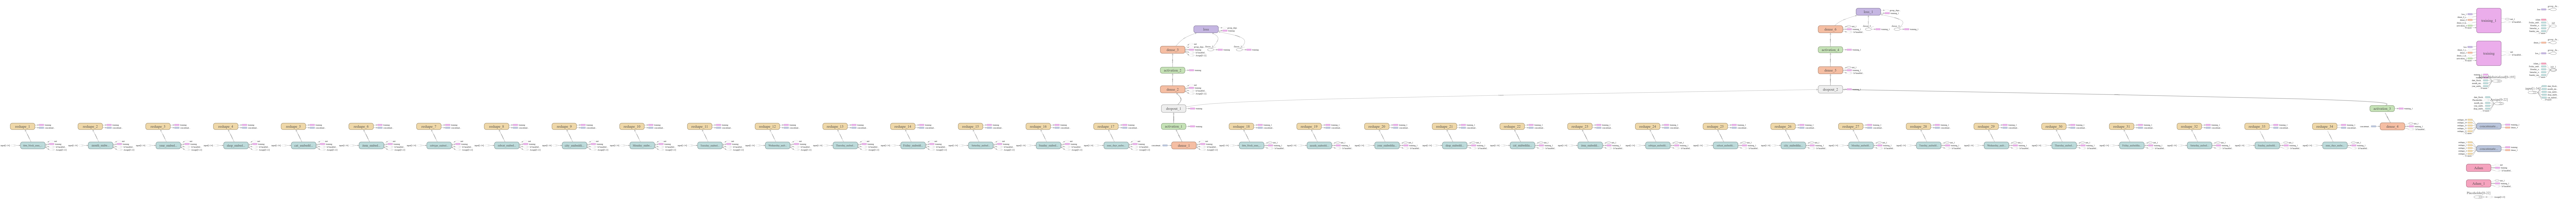

In [8]:
Image(filename='embedding_model.png')

In [97]:
val_months = [[32, 33], [30,31], [28,29], [26,27]]

In [98]:
def preprocessing(X):
    X_list = []
    
    date_block_num = X[..., [0]]
    X_list.append(date_block_num)

    month = X[..., [1]]
    X_list.append(month)

    year = X[..., [2]]
    X_list.append(year)

    shop_id = X[..., [3]]
    X_list.append(shop_id)
    
    item_cat = X[..., [4]]
    X_list.append(item_cat)

    item_id = X[..., [5]]
    X_list.append(item_id)
    
    subtype = X[..., [6]]
    X_list.append(subtype)
    
    subcat = X[..., [7]]
    X_list.append(subcat)
    
    city = X[..., [8]]
    X_list.append(city)
    
    Monday = X[..., [9]]
    X_list.append(Monday)

    Tuesday = X[..., [10]]
    X_list.append(Tuesday)
    
    Wednesday = X[..., [11]]
    X_list.append(Wednesday)
    
    Thursday = X[..., [12]]
    X_list.append(Thursday)
    
    Friday = X[..., [13]]
    X_list.append(Friday)
    
    Saturday = X[..., [14]]
    X_list.append(Saturday)
    
    Sunday = X[..., [15]]
    X_list.append(Sunday)
    
    num_days = X[..., [16]]
    X_list.append(num_days)
    
    return X_list

In [99]:
def scaler(y_scaler, y_train, y_val):
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1))
    y_val_scaled = y_scaler.transform(y_val.values.reshape(-1,1))
    return y_train_scaled, y_val_scaled

def rescaler(y_scaler, pred):
    result_rescaled = y_scaler.inverse_transform(pred.reshape(-1,1))
    return result_rescaled

In [100]:
train = shuffle(train)

In [101]:
epochs = 20
stopper = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
tensorboard = TensorBoard(log_dir='./logs/emb', histogram_freq=0, write_graph=False, batch_size=512)

In [113]:
for i in range(len(val_months)):
    checkpointer = ModelCheckpoint(filepath='best_model_weights_'+str(i)+'.hdf5', verbose=1, save_best_only=True, monitor='val_loss')
    val = train.loc[(train.date_block_num == val_months[i][0])|(train.date_block_num == val_months[i][1])]
    ktrain = train.loc[(train.date_block_num != val_months[i][0])&(train.date_block_num != val_months[i][1])]
    X_train = ktrain.drop('item_cnt_month', axis=1)
    y_train = ktrain['item_cnt_month']
    X_val = val.drop('item_cnt_month', axis=1)
    y_val = val['item_cnt_month']
    y_train = y_train.clip(0,50)
    y_val = y_val.clip(0,50)
    y_scaler = MinMaxScaler()
    y_train_scaled, y_val_scaled = scaler(y_scaler, y_train, y_val)

    
    date_block_num_input = Input(shape=(1,))
    date_block_num_output = Embedding(num_date_block, int(min(np.ceil(num_date_block/2), 50)), name='date_block_num_embedding')(date_block_num_input)
    date_block_num_output = Reshape(target_shape=(int(min(np.ceil(num_date_block/2), 50)),))(date_block_num_output)
    month_input = Input(shape=(1,))
    month_output = Embedding(12, 6, name='month_embedding')(month_input)
    month_output = Reshape(target_shape=(6,))(month_output)
    year_input = Input(shape=(1,))
    year_output = Embedding(3, 2, name='year_embedding')(year_input)
    year_output = Reshape(target_shape=(2,))(year_output)
    shop_input = Input(shape=(1,))
    shop_output = Embedding(num_shop, int(min(np.ceil(num_shop/2), 50)), name='shop_embedding')(shop_input)
    shop_output = Reshape(target_shape=(int(min(np.ceil(num_shop/2), 50)),))(shop_output)
    cat_input = Input(shape=(1,))
    cat_output = Embedding(num_cat, int(min(np.ceil(num_cat/2), 50)), name='cat_embedding')(cat_input)
    cat_output = Reshape(target_shape=(int(min(np.ceil(num_cat/2), 50)),))(cat_output)
    item_input = Input(shape=(1,))
    item_output = Embedding(num_item, int(min(np.ceil(num_item/2), 50)), name='item_embedding')(item_input)
    item_output = Reshape(target_shape=(int(min(np.ceil(num_item/2), 50)),))(item_output)
    subtype_input = Input(shape=(1,))
    subtype_output = Embedding(num_subtype, int(min(np.ceil(num_subtype/2), 50)), name='subtype_embedding')(subtype_input)
    subtype_output = Reshape(target_shape=(int(min(np.ceil(num_subtype/2), 50)),))(subtype_output)
    subcat_input = Input(shape=(1,))
    subcat_output = Embedding(num_subcat, int(min(np.ceil(num_subcat/2), 50)), name='subcat_embedding')(subcat_input)
    subcat_output = Reshape(target_shape=(int(min(np.ceil(num_subcat/2), 50)),))(subcat_output)
    city_input = Input(shape=(1,))
    city_output = Embedding(num_city, int(min(np.ceil(num_city/2), 50)), name='city_embedding')(city_input)
    city_output = Reshape(target_shape=(int(min(np.ceil(num_city/2), 50)),))(city_output)
    Monday_input = Input(shape=(1,))
    Monday_output = Embedding(2, 1, name='Monday_embedding')(Monday_input)
    Monday_output = Reshape(target_shape=(1,))(Monday_output)
    Tuesday_input = Input(shape=(1,))
    Tuesday_output = Embedding(2, 1, name='Tuesday_embedding')(Tuesday_input)
    Tuesday_output = Reshape(target_shape=(1,))(Tuesday_output)
    Wednesday_input = Input(shape=(1,))
    Wednesday_output = Embedding(2, 1, name='Wednesday_embedding')(Wednesday_input)
    Wednesday_output = Reshape(target_shape=(1,))(Wednesday_output)
    Thursday_input = Input(shape=(1,))
    Thursday_output = Embedding(2, 1, name='Thursday_embedding')(Thursday_input)
    Thursday_output = Reshape(target_shape=(1,))(Thursday_output)
    Friday_input = Input(shape=(1,))
    Friday_output = Embedding(2, 1, name='Friday_embedding')(Friday_input)
    Friday_output = Reshape(target_shape=(1,))(Friday_output)
    Saturday_input = Input(shape=(1,))
    Saturday_output = Embedding(2, 1, name='Saturday_embedding')(Saturday_input)
    Saturday_output = Reshape(target_shape=(1,))(Saturday_output)
    Sunday_input = Input(shape=(1,))
    Sunday_output = Embedding(2, 1, name='Sunday_embedding')(Sunday_input)
    Sunday_output = Reshape(target_shape=(1,))(Sunday_output)
    num_days_input = Input(shape=(1,))
    num_days_output = Embedding(3, 2, name='num_days_embedding')(num_days_input)
    num_days_output = Reshape(target_shape=(2,))(num_days_output)


    input_model = [date_block_num_input, month_input, year_input, shop_input, cat_input, item_input,
                  subtype_input, subcat_input, city_input, Monday_input, Tuesday_input, Wednesday_input,
                  Thursday_input, Friday_input, Saturday_input, Sunday_input, num_days_input]

    output_embeddings = [date_block_num_output, month_output, year_output, shop_output, cat_output, item_output,
                        subtype_output, subcat_output, city_output, Monday_output, Tuesday_output, Wednesday_output,
                        Thursday_output, Friday_output, Saturday_output, Sunday_output, num_days_output]

    output_model = Concatenate()(output_embeddings)

    output_model = Dense(500, kernel_initializer="uniform")(output_model)

    output_model = Activation('relu')(output_model)
    
    output_model = Dropout(0.1)(output_model)

    output_model = Dense(100, kernel_initializer="uniform")(output_model)

    output_model = Activation('relu')(output_model)
    
    output_model = Dense(1)(output_model)

    model = Model(inputs=input_model, outputs=output_model)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(preprocessing(X_train.values), y_train_scaled ,validation_data=(preprocessing(X_val.values), y_val_scaled),
              callbacks=[checkpointer, stopper, tensorboard],epochs=epochs, batch_size=512)
    model.load_weights(filepath='best_model_weights_'+str(i)+'.hdf5')
    features = preprocessing(X_val.values)
    result = model.predict(features).flatten()
    result_rescaled = rescaler(y_scaler, result)
    rmse = np.sqrt(mean_squared_error(y_val, result_rescaled))
    print('Validation Root Mean Squared Error =', rmse)

Train on 12530976 samples, validate on 698199 samples
Epoch 1/20
12530976/12530976 [==============================] - 971s 78us/step - loss: 4.4840e-04 - val_loss: 6.8916e-04

Epoch 00001: val_loss improved from inf to 0.00069, saving model to best_model_weights_0.hdf5
Epoch 2/20
12530976/12530976 [==============================] - 972s 78us/step - loss: 2.9868e-04 - val_loss: 6.7577e-04

Epoch 00002: val_loss improved from 0.00069 to 0.00068, saving model to best_model_weights_0.hdf5
Epoch 3/20
12530976/12530976 [==============================] - 1003s 80us/step - loss: 2.6072e-04 - val_loss: 6.2479e-04

Epoch 00003: val_loss improved from 0.00068 to 0.00062, saving model to best_model_weights_0.hdf5
Epoch 4/20
12530976/12530976 [==============================] - 1008s 80us/step - loss: 2.4288e-04 - val_loss: 6.3769e-04

Epoch 00004: val_loss did not improve from 0.00062
Epoch 5/20
12530976/12530976 [==============================] - 960s 77us/step - loss: 2.2907e-04 - val_loss: 6.223

## Results evaluation

We trained the model in a self created k-fold validation process. After each fold we measured the performance of the model on the validation set. Validation consisted of selected 2 months from the dataframe. So, we come up with four different models and get an evaluation on each of them. The metric we are supposed to minimize is the Root Mean Squared Error, so we calculate it for each model. 

The results on the validation sets are as follows:

- First Model: RMSE = 1.22
- Second Model: RMSE = 0.888
- Third Model: RMSE = 1.07
- Fourth Model: RMSE = 1.15

The results seem extremely good, as we are able to predict the sales of a certain item, at a certain shop, with an error of around 1 item, just using entity embeddings.

The last step is to create the submission file. First, I predict the `item_cnt_month` with all four models, and take the mean of these predictions as my final prediction. I also use the previously computed list of expected values of 0 at certain shop - item pairs, and insert the 0s where they are expected.

In [106]:
for i in range(len(val_months)):
    model.load_weights(filepath='best_model_weights_'+str(i)+'.hdf5')
    features = preprocessing(test.values)
    if i ==0:
        test_res = model.predict(features).flatten()
        test_res = rescaler(y_scaler, test_res).flatten()
        test_res = pd.Series(test_res, name='item_cnt_month')
        test_res = pd.concat([test.reset_index(), test_res], axis=1)
        test_res = test_res[['shop_id', 'item_id', 'item_cnt_month']]
        test_res = pd.concat([pd.Series(shop_encoder.inverse_transform(test_res.shop_id.values),name='shop_id'),
                             pd.Series(item_encoder.inverse_transform(test_res.item_id.values),name='item_id'),
                             pd.Series(test_res.item_cnt_month.values, name='item_cnt_month_'+str(i))], axis=1)
    else:
        test_pred = model.predict(features).flatten()
        test_pred = pd.Series(rescaler(y_scaler, test_pred).flatten(),name='item_cnt_month_'+str(i))
        test_res = pd.concat([test_res, test_pred], axis=1)

C:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [111]:
test_res['item_cnt_month'] = (test_res.item_cnt_month_0 + test_res.item_cnt_month_1 + test_res.item_cnt_month_2 + test_res.item_cnt_month_3)/4

In [114]:
orig_test = pd.read_csv('test.csv', index_col='ID')

orig_test = orig_test.merge(test_res, how='left', on=['shop_id', 'item_id']).drop(['item_cnt_month_0', 'item_cnt_month_1', 'item_cnt_month_2','item_cnt_month_3'], axis=1)

In [119]:
zeros = pd.DataFrame(np.asarray(drop_list), columns=['shop_id', 'item_id'])

zeros['item_cnt'] = 0

In [124]:
orig_test = orig_test.merge(zeros, how='left', on = ['shop_id', 'item_id'])

orig_test.item_cnt.fillna(orig_test.item_cnt_month, inplace=True)

In [131]:
sub = orig_test[['item_cnt']].reset_index()

sub.columns = ['ID', 'item_cnt_month']

sub.set_index('ID', inplace=True)

sub = sub.clip(0,20)

In [137]:
sub.to_csv('final_submission.csv')

## Conclusion and future work

The predictions score is 1.2 RMSE on the test set, which is not bad at all. The score could obviously be better, but with the use of only categorical variables it seems that the result is extremely good, and similiar to the scores obtained on validation sets.

To conclude, the choice of the model, and the features I decided to use turned out to be good. Creation of such a complicated neural network, and observing how it improved through time was a really satisfying experience. The crucial thing about the approach I have taken, is that this neural network is tailor made for the problem, which means it would not work with any other data. Every embedding layer is exclusively created for each input, in order to make training as efficient as possible.

As for future work, there are many ways we can try and improve the performance of the model. The areas in which there may be room for improvement, in my opinion, are:

- Most importantly - adding numerical data, as additional inputs to the model. Data concerning prices, lagged sales values for items, for shops, for item categories. All of that can significantly improve the model's predictions.
- Working on model's hyperparameters. Adding or removing layers, adding regularization, changing the dropout ratio, changing the activation functions - it all can improve the model's performance.
- Using gradient boosting algorithms, ensemble models, like `XGBoost` or `LightGBM`. They are well known for their great performance in Kaggle competitions. We could use them as an addition to our Neural Network.

Thank you for reading!
Piotr Gloger